In [1]:
import numpy as np
# 创建数据结构
InputLayerC = 784
HiddenLayerC = 300
OutputLayerC = 10

Omega1 = np.random.normal(0, 0.05, (InputLayerC, HiddenLayerC)) # 缩小初始化的参数值，让最后一层的sigmoid激活函数的输入不至于太大，导致梯度消失
Theta1 = np.random.normal(0, 0.05, (1, HiddenLayerC))

Omega2 = np.random.normal(0, 0.05, (HiddenLayerC, OutputLayerC))
Theta2 = np.random.normal(0, 0.05, (1, OutputLayerC))

# 定义全局变量
LearnRate1 = 0.0002    #救命，我好傻逼，之前的学习率统统都太高了，降低之后看起来好多了
LearnRate2 = 0.0002
Alpha = 0.1       #平滑系数
LAMBDA = 0.9      #正则化好像没有用，取1表示不进行正则化
augmentRateFalse = 1  #惩罚的学习率的修正系数（增加惩罚的学习率），救，起反作用了，1表示没有修改
print('fini')

fini


In [2]:
# 导入数据
from datareader import *
Reader = MNISTReader(mode=1)
TrainSetSize = Reader.get_pic_count()

# 区分验证集和训练集
TrainRate = 0.8
from random import shuffle
DataList = [i for i in range(1, TrainSetSize+1)]
shuffle(DataList)
TrainSet = DataList
print('fini')

fini


In [3]:
# 定义支持的数学函数
def sigmoid(x):
    return 1 / (1 + pow(np.e, -x))

def delta_sigmoid(x):
    # 不保证不出错
    return x * (1-x)

# Q1 这个迭代是in place的，但在当前工程中不存在问题，只是是一个隐患

def ReLU(x):
    # 输入的x是numpy的array
    if type(x) == type(1):
        return max(0, x)
    else:
        with np.nditer(x, op_flags=['readwrite']) as it:
           for item in it:
               item[...] = max(item, 0)
        return x
        
def delta_Relu(x):
    if type(x) == type(1):
        return 1 if x > 0 else 0
    else:
        with np.nditer(x, op_flags=['readwrite']) as it:
           for item in it:
               item[...] = 1 if item > 0 else 0
        return x


def softmax(Yhat):
    exped = np.exp(Yhat)
    x_sum = np.sum(exped, axis=1, keepdims=True)
    return exped / x_sum
    

def CrossEntropy(modelRe, y):
    Y = np.array([[Alpha/OutputLayerC for i in range(OutputLayerC)]])
    Y[0][y] += 1 - Alpha
    return -np.sum(np.log2(modelRe) * Y)


def BatchNormalization(data, scale=2.3, shift=0):
    # a b 表示标准化的上界和下界
    mean = np.mean(data)
    std = (np.std(data) + 0.001)
    return ((data - mean)/std)*scale + shift
    

In [4]:
def predict(pixels):
    global Omega1, Omega2, Theta1, Theta2
    x_l = pixels
    x_l = np.array(x_l).reshape(1, InputLayerC)
    #HiddenOut = ReLU(BatchNormalization(np.dot(x_l, Omega1) - Theta1))  # 较之上一个模型，隐含层的激活函数变成了ReLU
    HiddenOut = ReLU(np.dot(x_l, Omega1) - Theta1)
    YHat = sigmoid(np.dot(HiddenOut, Omega2) - Theta2)
    #加入一个BatchNormalization
    outputX = BatchNormalization(YHat)
    return softmax(YHat)


# train
def train_StdBP_regulated(x, y, Falg=0):
    #正则化的
    # Falg = 0  是否print中间参数
    global Omega1, Omega2, Theta1, Theta2
    x_l = np.array(x).reshape(1, InputLayerC)
    Hidden_ReLU_x = np.dot(x_l, Omega1) - Theta1
    #HiddenOut = ReLU(BatchNormalization(Hidden_ReLU_x))
    HiddenOut = ReLU(Hidden_ReLU_x)
    outputX = np.dot(HiddenOut, Omega2) - Theta2  #输出层激活函数的x
    #加入一个BatchNormalization
    outputX = BatchNormalization(outputX)
    YHat = sigmoid(outputX)
    if(Falg): print('outputX: ', outputX)
    if(Falg): print('YHat', YHat)
    if(Falg): print(f'正确答案{y}')
    yhat_softmax = softmax(YHat)
    # 计算损失函数 在每一个yhat上的梯度                                                #！！！！！！！！这里可能有大bug
    LF_Yhat = (yhat_softmax - Alpha/OutputLayerC) * augmentRateFalse
    LF_Yhat[0][y] = LF_Yhat[0][y]/augmentRateFalse + Alpha - 1
    if(Falg): print('LF_Yhat: ', LF_Yhat)
    g_j = YHat * (1 - YHat) * LF_Yhat
    if(Falg): print('g_j: ', g_j)

    delta_w = LearnRate1 * g_j * HiddenOut.reshape(HiddenLayerC, 1)
    #print('hidden_out: ', HiddenOut)
    if(Falg): print('delta_w', delta_w)

    #print("隐含层到输出层权重更新 delta_w:")
    #print(delta_w)
    Omega2 = Omega2 - LAMBDA * delta_w - LearnRate1 * (2-2 * LAMBDA) * Omega2
    #print(Omega2)
    aaa = np.sum(np.absolute(delta_w))/(HiddenLayerC * OutputLayerC)
    
    Theta2 = Theta2 + LearnRate1 * g_j * LAMBDA - LearnRate1 * (2-2 * LAMBDA) * Theta2
    #print(Theta2)
    
    delta_e = delta_Relu(HiddenOut) * np.dot(g_j, Omega2.reshape(OutputLayerC, HiddenLayerC))  # 也可能有bug！！！！！！！！！
   
    #delta_e = HiddenOut * (1 - HiddenOut) * np.dot(g_j, Omega2.reshape(OutputLayerC, HiddenLayerC))  # 试试也改成Softmax，但是记得也该前面的码
    if(Falg): print('delta_e: ', delta_e)  #shape (1,9)

    delta_v = LearnRate2 * delta_e * x_l.reshape(InputLayerC, 1)    # 这里可能存在过多delta v 为0的情况
    Omega1 = Omega1 - LAMBDA * delta_v - LearnRate2 * (2-2 * LAMBDA) * Omega1
    Theta1 = Theta1 + LearnRate2 * delta_e * LAMBDA - LearnRate2 * (2-2 * LAMBDA) * Theta1
    
    bbb = np.sum(np.absolute(delta_v))/(HiddenLayerC * InputLayerC)
    return (aaa, bbb)  #先不写综合BP，但是返回参数修改的平均值
    
def train_StdBP(x, y, Falg=0):
    #Falg = 0
    global Omega1, Omega2, Theta1, Theta2
    x_l = np.array(x).reshape(1, InputLayerC)
    Hidden_ReLU_x = np.dot(x_l, Omega1) - Theta1
    #HiddenOut = ReLU(BatchNormalization(Hidden_ReLU_x))
    HiddenOut = ReLU(Hidden_ReLU_x)
    outputX = np.dot(HiddenOut, Omega2) - Theta2  #输出层激活函数的x
    #加入一个BatchNormalization
    outputX = BatchNormalization(outputX)
    YHat = sigmoid(outputX)
    if(Falg): print('outputX: ', outputX)
    if(Falg): print('YHat', YHat)
    if(Falg): print(f'正确答案{y}')
    yhat_softmax = softmax(YHat)
    # 计算损失函数 在每一个yhat上的梯度                                                #！！！！！！！！这里可能有大bug
    LF_Yhat = (yhat_softmax - Alpha/OutputLayerC) * augmentRateFalse
    LF_Yhat[0][y] = LF_Yhat[0][y]/augmentRateFalse + Alpha - 1
    if(Falg): print('LF_Yhat: ', LF_Yhat)
    g_j = YHat * (1 - YHat) * LF_Yhat
    if(Falg): print('g_j: ', g_j)

    delta_w = LearnRate1 * g_j * HiddenOut.reshape(HiddenLayerC, 1)
    #print('hidden_out: ', HiddenOut)
    if(Falg): print('delta_w', delta_w)

    #print("隐含层到输出层权重更新 delta_w:")
    #print(delta_w)
    Omega2 = Omega2 - delta_w
    #print(Omega2)
    aaa = np.sum(np.absolute(delta_w))/(HiddenLayerC * OutputLayerC)
    
    Theta2 = Theta2 + LearnRate1 * g_j
    #print(Theta2)
    
    delta_e = delta_Relu(HiddenOut) * np.dot(g_j, Omega2.reshape(OutputLayerC, HiddenLayerC))  # 也可能有bug！！！！！！！！！
   
    #delta_e = HiddenOut * (1 - HiddenOut) * np.dot(g_j, Omega2.reshape(OutputLayerC, HiddenLayerC))  # 试试也改成Softmax，但是记得也该前面的码
    if(Falg): print('delta_e: ', delta_e)  #shape (1,9)

    delta_v = LearnRate2 * delta_e * x_l.reshape(InputLayerC, 1)    # 这里可能存在过多delta v 为0的情况
    Omega1 = Omega1 - delta_v
    Theta1 = Theta1 + LearnRate2 * delta_e
    
    bbb = np.sum(np.absolute(delta_v))/(HiddenLayerC * InputLayerC)
    
    return (aaa, bbb)  #先不写综合BP，但是返回参数修改的平均值


def train_CummBP(xinput):
    
    Falg = 0
    global Omega1, Omega2, Theta1, Theta2, Reader
    Size = len(xinput)
    delta_v = np.zeros((InputLayerC, HiddenLayerC))
    delta_e = np.zeros((1, HiddenLayerC))
    delta_w = np.zeros((HiddenLayerC, OutputLayerC))
    g_j = np.zeros((1, OutputLayerC))
    
    for i in range(Size):
        pdata = Reader.get_pic(xinput[i])
        x_l = np.array(pdata[0]).reshape(1, InputLayerC)
        Hidden_ReLU_x = np.dot(x_l, Omega1) - Theta1
        #HiddenOut = ReLU(BatchNormalization(Hidden_ReLU_x))
        HiddenOut = ReLU(Hidden_ReLU_x)
        outputX = np.dot(HiddenOut, Omega2) - Theta2  #输出层激活函数的x
        #加入一个BatchNormalization
        outputX = BatchNormalization(outputX)
        YHat = sigmoid(outputX)
        yhat_softmax = softmax(YHat)
        # 计算损失函数 在每一个yhat上的梯度                                                #！！！！！！！！这里可能有大bug
        LF_Yhat = (yhat_softmax - Alpha/OutputLayerC) * augmentRateFalse
        LF_Yhat[0][pdata[1]] = LF_Yhat[0][pdata[1]]/augmentRateFalse + Alpha - 1   
        g_j_local = YHat * (1 - YHat) * LF_Yhat
        delta_w += LearnRate1 * g_j_local * HiddenOut.reshape(HiddenLayerC, 1)
        g_j += g_j_local
        delta_e_local = delta_Relu(HiddenOut) * np.dot(g_j_local, Omega2.reshape(OutputLayerC, HiddenLayerC))  # 也可能有bug！！！！！！！！！
        delta_v += LearnRate2 * delta_e_local * x_l.reshape(InputLayerC, 1)    # 这里可能存在过多delta v 为0的情况
        delta_e += delta_e_local

    # 考虑是否正则化  
    Omega2 = Omega2 - delta_w  * LAMBDA - LearnRate1 * (2-2 * LAMBDA) * Omega2
    Theta2 = Theta2 + LearnRate1 * g_j  * LAMBDA - LearnRate1 * (2-2 * LAMBDA) * Theta2
    Omega1 = Omega1 - delta_v  * LAMBDA - LearnRate2 * (2-2 * LAMBDA) * Omega1
    Theta1 = Theta1 + LearnRate2 * delta_e  * LAMBDA - LearnRate2 * (2-2 * LAMBDA) * Theta1 
    
    aaa = np.sum(np.absolute(delta_w))/(HiddenLayerC * OutputLayerC)
    bbb = np.sum(np.absolute(delta_v))/(HiddenLayerC * InputLayerC)
    # 返回一下两层总梯度的变化
    return (aaa, bbb)
print('fini')

fini


In [5]:
# 尝试训练

OutputOmega1 = np.zeros((InputLayerC, HiddenLayerC)) 
OutputTheta1 = np.zeros((1, HiddenLayerC))
OutputOmega2 = np.zeros((HiddenLayerC, OutputLayerC))
OutputTheta2 = np.zeros((1, OutputLayerC))
OutputIter = 0

verify_Reader = MNISTReader(2)
verify_Len = verify_Reader.total_img
verify_l = [i for i in range(1, verify_Len + 1)]
iter = 1
test_l = [(0, 100000, 100)]  #记录迭代次数，累积交叉熵和错误率
lastFalse = 1

IterSize = 100 #一次迭代的训练数量


for epoch in range(5):
    for iter in range(0, 600):
        curchange = [0, 0]
        shuffle(TrainSet)
        if iter%588 == 0:
            LearnRate1 -= 0.00002
            LearnRate2 -= 0.00002
        if lastFalse <= 0.35:
            # 标准BP
            for i in range(IterSize):
                #print(f"第{iter}遍遍历训练集， 第{i+1}条记录")
                pdata = Reader.get_pic(TrainSet[IterSize*iter + i])
                record = train_StdBP_regulated(pdata[0], pdata[1])
                curchange[0] += record[0]
                curchange[1] += record[1]
                #input(f'w和v参数的平均修改量为{record[0]}和{record[1]}，输入任意数值继续')'''
        if lastFalse > 0.35:
            # 累积BP训练
            curchange = train_CummBP(TrainSet[IterSize * iter:(iter + 1) * IterSize])
        
        # 计算平均交叉熵
        shuffle(verify_l)
        var = []
        wrong_count = 0
        for item in verify_l[:]:
            pic = verify_Reader.get_pic(item)
            modelre = predict(pic[0])
            var.append(CrossEntropy(modelre, pic[1]))
            model_number = np.argmax(modelre)
            if model_number != pic[1]:
                wrong_count += 1
    
        #print(var)
        mean_var = sum(var)/len(var)
        false_rate = wrong_count/len(var)
        # 计算验证正确率
        print(f"epoch:{epoch}, iter:{iter}: 验证集平均交叉熵为{mean_var}，错误率{false_rate}，w和v参数的平均修改量为{curchange[0]}和{curchange[1]}")
        if lastFalse > false_rate:
            lastFalse = false_rate
            OutputIter = iter + 600 * epoch
            OutputOmega1 = np.array(Omega1)
            OutputOmega2 = np.array(Omega2)
            OutputTheta1 = np.array(Theta1)
            OutputTheta2 = np.array(Theta2)
        if iter+600*epoch - OutputIter > 150:   #20次都没有更新更优秀，退出
            break
    
        test_l.append((iter+600*epoch, mean_var, false_rate))
        
print(f'训练结束，最优情况错误率{lastFalse}')
Omega1 = OutputOmega1
Omega2 = OutputOmega2
Theta1 = OutputTheta1
Theta2 = OutputTheta2

# 验证集的交叉熵似乎是比正确率更重要的评价过拟合的指标

KeyboardInterrupt: 

In [ ]:
#绘图
import matplotlib.pyplot as plt

x = [x[0] for x in test_l[1:]]
y1 = [x[1] for x in test_l[1:]]
y2 = [x[2] for x in test_l[1:]]

plt.figure(figsize=(40, 10), dpi=100)
plt.rc("font", family='MicroSoft YaHei', weight="bold")

plt.subplot(1, 2, 1)
plt.xlabel('迭代次数')
plt.ylabel('验证集交叉熵')
plt.plot(x, y1)

plt.subplot(1, 2, 2)
plt.xlabel('迭代次数')
plt.ylabel('错误率')
plt.plot(x, y2)

plt.show()



In [ ]:
# 中途test 模块
'''
verify_Reader = MNISTReader(2)
verify_Len = verify_Reader.total_img
verify_l = [i for i in range(1, verify_Len + 1)]
iter = 1
test_l = [(0, 100000, 100)]  #记录迭代次数，累积交叉熵和错误率
lastFalse = 1
while iter < 10000:
    system('cls')
    curchange = [0, 0]
    shuffle(TrainSet)
    # 标准BP
    for i in range(100):
        #print(f"第{iter}遍遍历训练集， 第{i+1}条记录")
        pdata = Reader.get_pic(TrainSet[i])
        record = train_StdBP(pdata[0], pdata[1], Falg=1)
        curchange[0] += record[0]
        curchange[1] += record[1]
        input(f'w和v参数的平均修改量为{record[0]}和{record[1]}，输入任意数值继续')
    
    # 计算平均交叉熵
    shuffle(verify_l)
    var = []
    wrong_count = 0
    for item in verify_l[:]:
        pic = verify_Reader.get_pic(item)
        modelre = predict(pic[0])
        var.append(CrossEntropy(modelre, pic[1]))
        model_number = np.argmax(modelre)
        if model_number != pic[1]:
            wrong_count += 1

    #print(var)
    mean_var = sum(var)/len(var)
    false_rate = wrong_count/len(var)
    # 计算验证正确率
    print(f"验证集平均交叉熵为{mean_var}，错误率{false_rate}，w和v参数的平均修改量为{curchange[0]}和{curchange[1]}，按任意键第{iter+1}遍遍历数据")
    if lastFalse > false_rate:
        lastFalse = false_rate
    test_l.append((iter, mean_var, false_rate))
    iter += 1
    '''

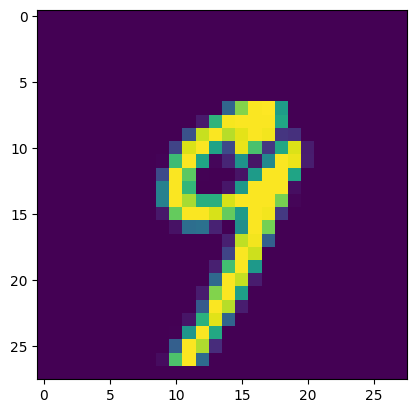

[[0.08050942 0.08291636 0.08020765 0.08629252 0.08526442 0.10238962
  0.12977942 0.1025413  0.13320377 0.11689552]]
模型预测数字为: 8，正确答案为: 9，

KeyboardInterrupt: Interrupted by user

In [6]:
# 展示效果
import matplotlib.pyplot as plt
import random
while True:
    #system('cls')
    seleted_p_id = random.randint(1, len(verify_l)-1)
    pdata = verify_Reader.get_pic(seleted_p_id)  #不敢从训练集内获取图片，怕出意外
    #pdata = Reader.get_pic(seleted_p_id)
    imdata = np.array(pdata[0]) * 255
    imdata = imdata.reshape((28, 28))
    #print(imdata)
    fig = plt.figure()
    plt.imshow(imdata)
    plt.show()
    predict_re = predict(pdata[0])
    print(predict_re)
    predict_num = np.argmax(predict_re)
    print(f'模型预测数字为: {predict_num}，正确答案为: {pdata[1]}，',end='')
    input('输入任意值继续: ')